#### Import packages for setting up the essential tools and libraries

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDClassifier, LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
import xgboost as xgb
import lightgbm as lgb
from scipy import interp
from sklearn.preprocessing import LabelBinarizer
import matplotlib.patches as patches
from sklearn.multiclass import OneVsRestClassifier
import eli5
from eli5.sklearn import PermutationImportance
pip install forestplot
import forestplot as fp
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning, module="my_module")
import warnings
warnings.simplefilter('ignore')


#### Read different window size data

In [ ]:
# Define a function to read X and y from CSV files
def read_x_y_from_csv(X_filename, y_filename):
    X = pd.read_csv(X_filename)
    y = pd.read_csv(y_filename)
    return X, y

X_0_5s_c, y_0_5s_c = read_x_y_from_csv('X_0_5s_c.csv', 'y_0_5s_c.csv')
X_1s_c, y_1s_c = read_x_y_from_csv('X_1s_c.csv', 'y_1s_c.csv')
X_2s_c, y_2s_c = read_x_y_from_csv('X_2s_c.csv', 'y_2s_c.csv')
X_3s_c, y_3s_c = read_x_y_from_csv('X_3s_c.csv', 'y_3s_c.csv')
X_4s_c, y_4s_c = read_x_y_from_csv('X_4s_c.csv', 'y_4s_c.csv')
X_5s_c, y_5s_c = read_x_y_from_csv('X_5s_c.csv', 'y_5s_c.csv')

X_0_5s_d, y_0_5s_d = read_x_y_from_csv('X_0_5s_d.csv', 'y_0_5s_d.csv')
X_1s_d, y_1s_d = read_x_y_from_csv('X_1s_d.csv', 'y_1s_d.csv')
X_2s_d, y_2s_d = read_x_y_from_csv('X_2s_d.csv', 'y_2s_d.csv')
X_3s_d, y_3s_d = read_x_y_from_csv('X_3s_d.csv', 'y_3s_d.csv')
X_4s_d, y_4s_d = read_x_y_from_csv('X_4s_d.csv', 'y_4s_d.csv')
X_5s_d, y_5s_d = read_x_y_from_csv('X_5s_d.csv', 'y_5s_d.csv')


### ROC AUC curve for two different response variables

#### Think-aloud

Processing 0
Processing 1
Processing 2
Processing 3
Processing 4
Processing 5


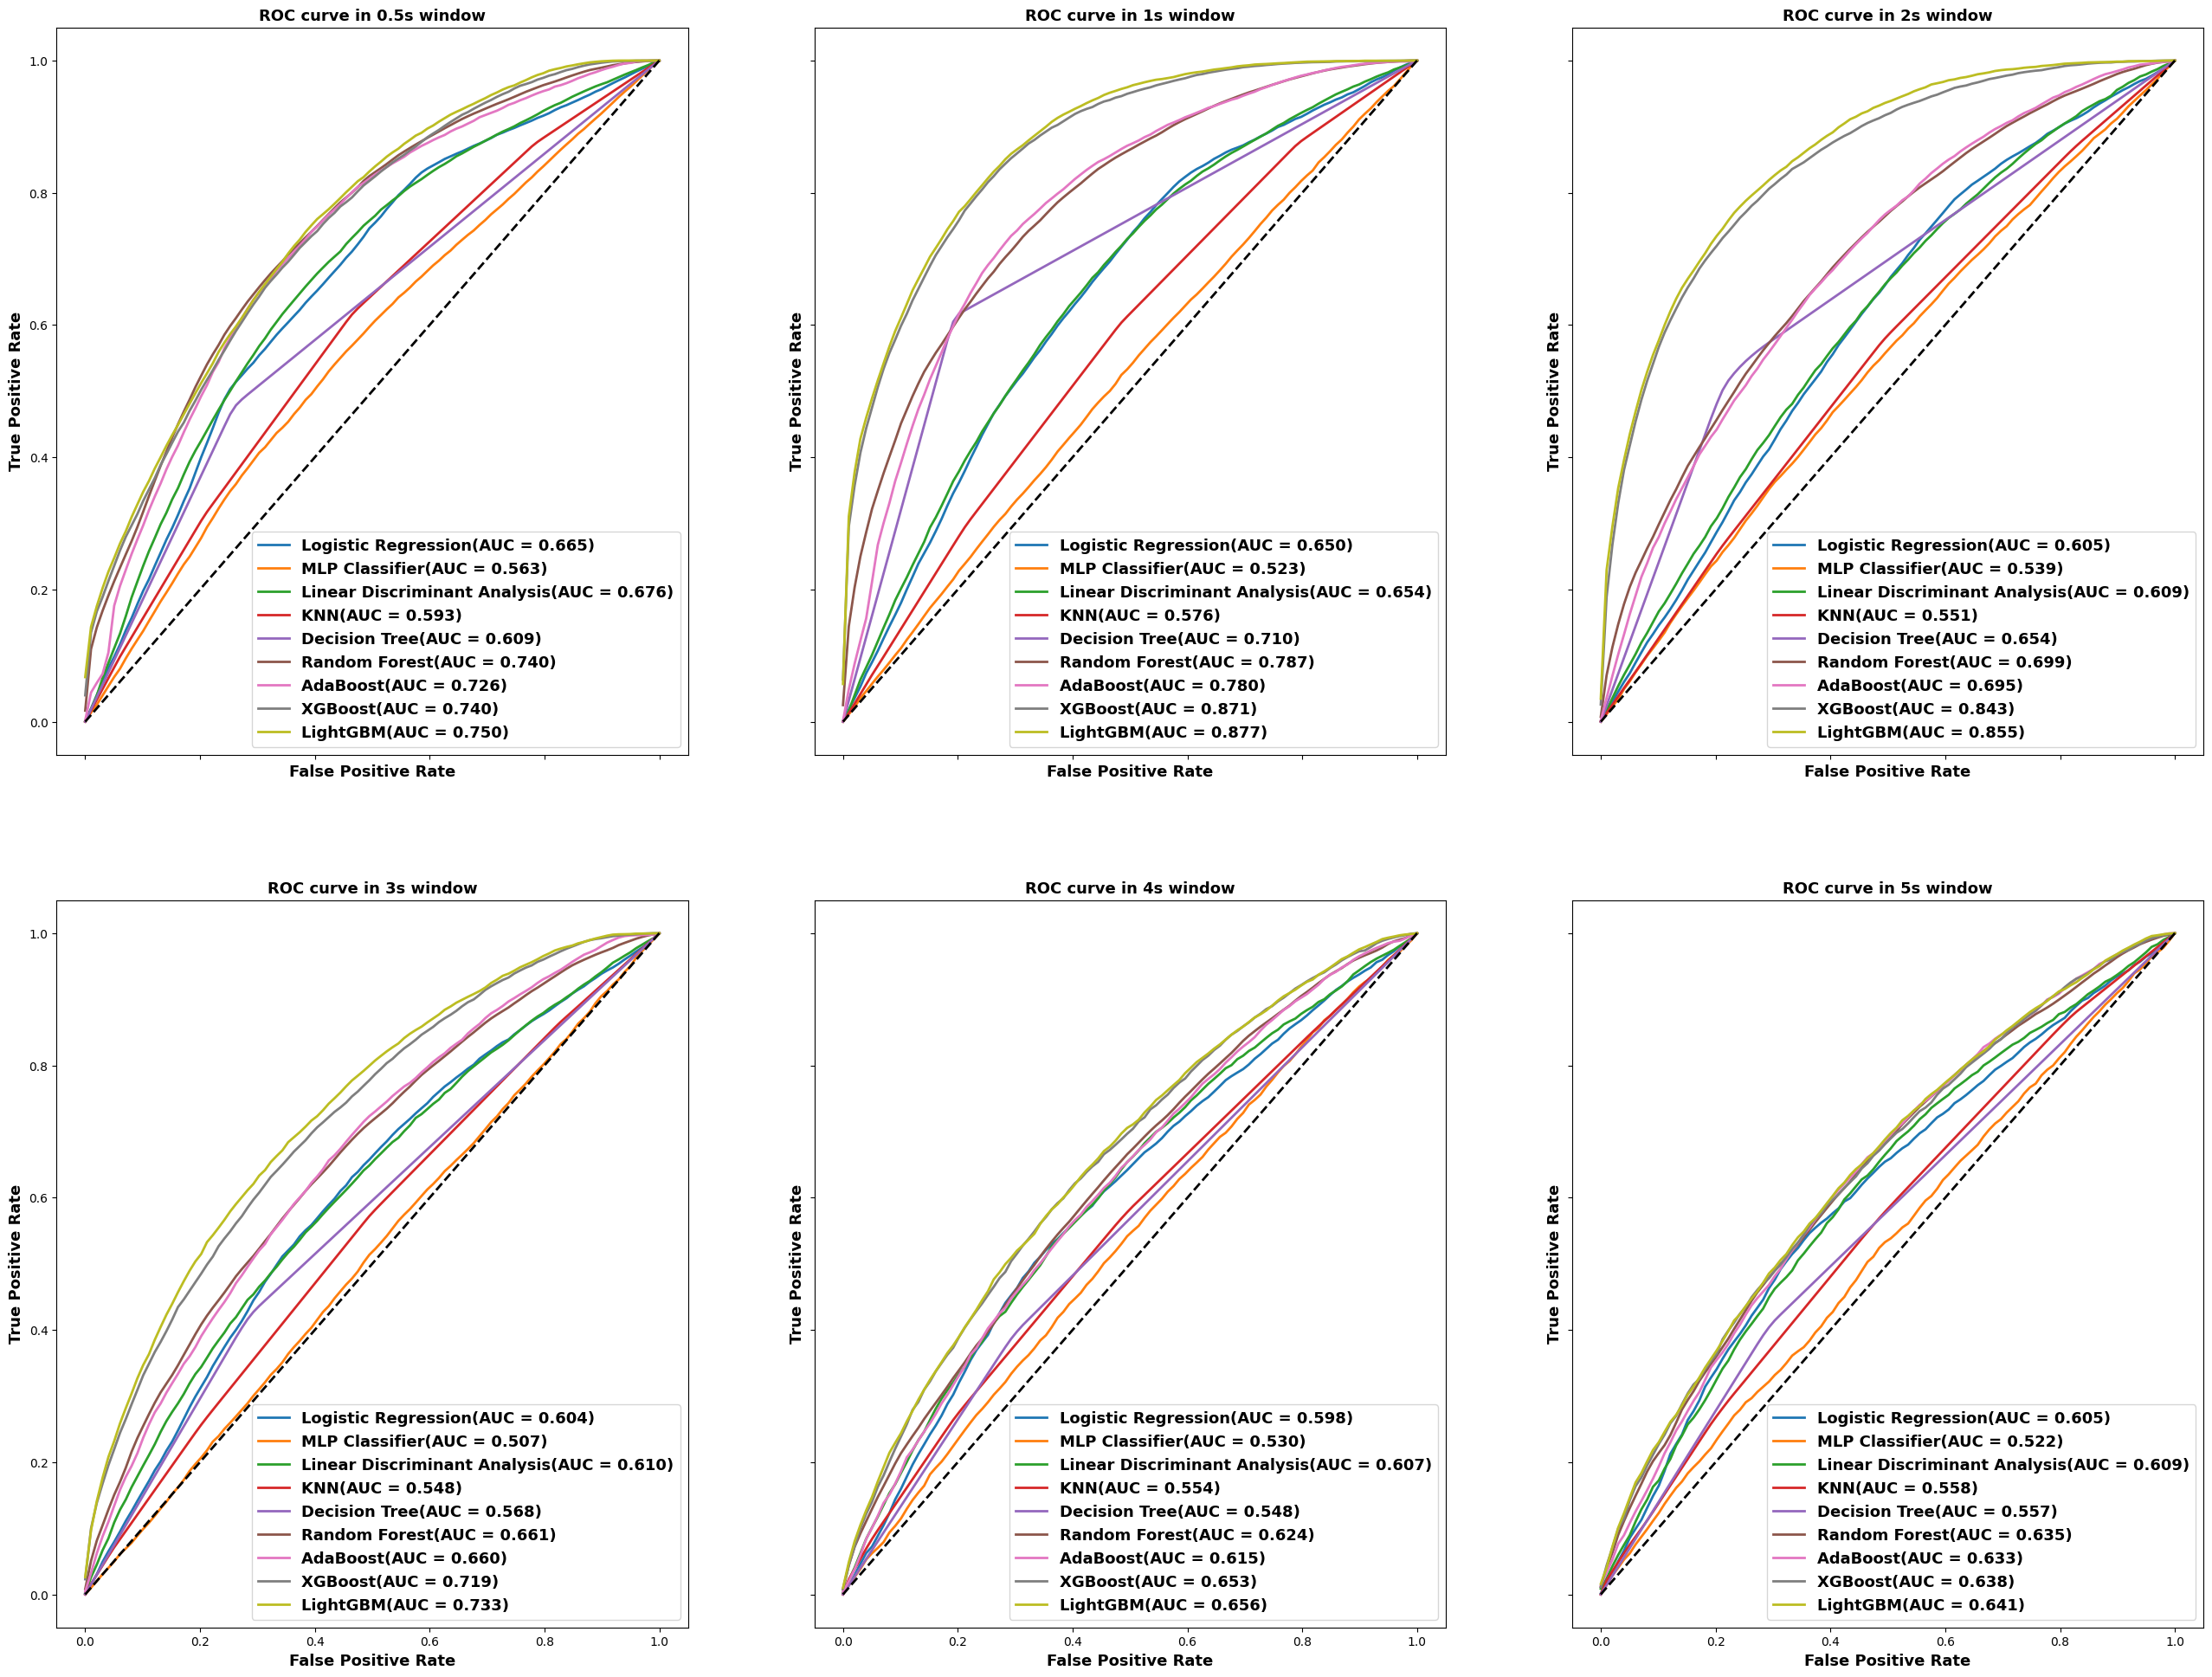

In [ ]:
datasets = [(X_0_5s_c, y_0_5s_c), (X_1s_c, y_1s_c), (X_2s_c, y_2s_c), (X_3s_c, y_3s_c), (X_4s_c, y_4s_c), (X_5s_c, y_5s_c)]
labels = [0.5, 1, 2, 3, 4, 5]
random_state = np.random.RandomState(0)
np.random.seed(0)

fig1, ax = plt.subplots(ncols=3, figsize=[32, 24], nrows=2, sharex=True, sharey=True)

class_combinations = [(0, [1, 2]), (1, [0, 2]), (2, [0, 1])]
class_labels = ['Baseline vs (CTA, CTA+RTA)', 'CTA vs (Baseline, CTA+RTA)', 'CTA+RTA vs (Baseline, CTA)']

for i, (x, y) in enumerate(datasets):
    print('Processing', i)
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=random_state)),
        ('MLP Classifier', MLPClassifier(random_state=random_state)),
        ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
        ('KNN', KNeighborsClassifier()),
        ('Decision Tree', DecisionTreeClassifier(random_state=random_state)),
        ('Random Forest', RandomForestClassifier(random_state=random_state)),
        ('AdaBoost', AdaBoostClassifier(random_state=random_state)),
        ('XGBoost', xgb.XGBClassifier(random_state=random_state)),
        ('LightGBM', lgb.LGBMClassifier(random_state=random_state))
    ]

    mean_fpr = np.linspace(0, 1, 100)

    mean_tprs_micro = []
    mean_aucs_micro = []

    for name, clf in classifiers:
        cv = KFold(n_splits=5, shuffle=True)
        tprs_micro = []
        aucs_micro = []

        for idx, (class_idx, rest_classes) in enumerate(class_combinations):
            for train, test in cv.split(x, y):
                clf.fit(x.iloc[train], y.iloc[train])
                prediction = clf.predict_proba(x.iloc[test])

                lb = LabelBinarizer()
                lb.fit(y)
                y_test_bin = lb.transform(y.iloc[test])
                y_test_bin_one_vs_rest = np.hstack((y_test_bin[:, class_idx].reshape(-1, 1), y_test_bin[:, rest_classes]))

                fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), prediction.ravel())
                tprs_micro.append(interp(mean_fpr, fpr_micro, tpr_micro))
                roc_auc_micro = auc(fpr_micro, tpr_micro)
                aucs_micro.append(roc_auc_micro)

        mean_tpr_micro = np.mean(tprs_micro, axis=0)
        mean_auc_micro = np.mean(aucs_micro)
        mean_tprs_micro.append(mean_tpr_micro)
        mean_aucs_micro.append(mean_auc_micro)

        ax.flat[i].plot(mean_fpr, mean_tpr_micro, label='%s(AUC = %0.3f)' % (name, mean_auc_micro), lw=2)

    ax.flat[i].plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
    ax.flat[i].set_xlabel('False Positive Rate', fontweight='bold', fontsize='13')
    ax.flat[i].set_ylabel('True Positive Rate', fontweight='bold', fontsize='13')
    ax.flat[i].set_title('ROC curve in ' + str(labels[i]) + 's window', fontweight='bold', fontsize='13')
    ax.flat[i].legend(loc='lower right', prop={'weight': 'bold', 'size': '13'})
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')

plt.show()


#### Distraction/Attention

Processing 0
Processing 1
Processing 2
Processing 3
Processing 4
Processing 5


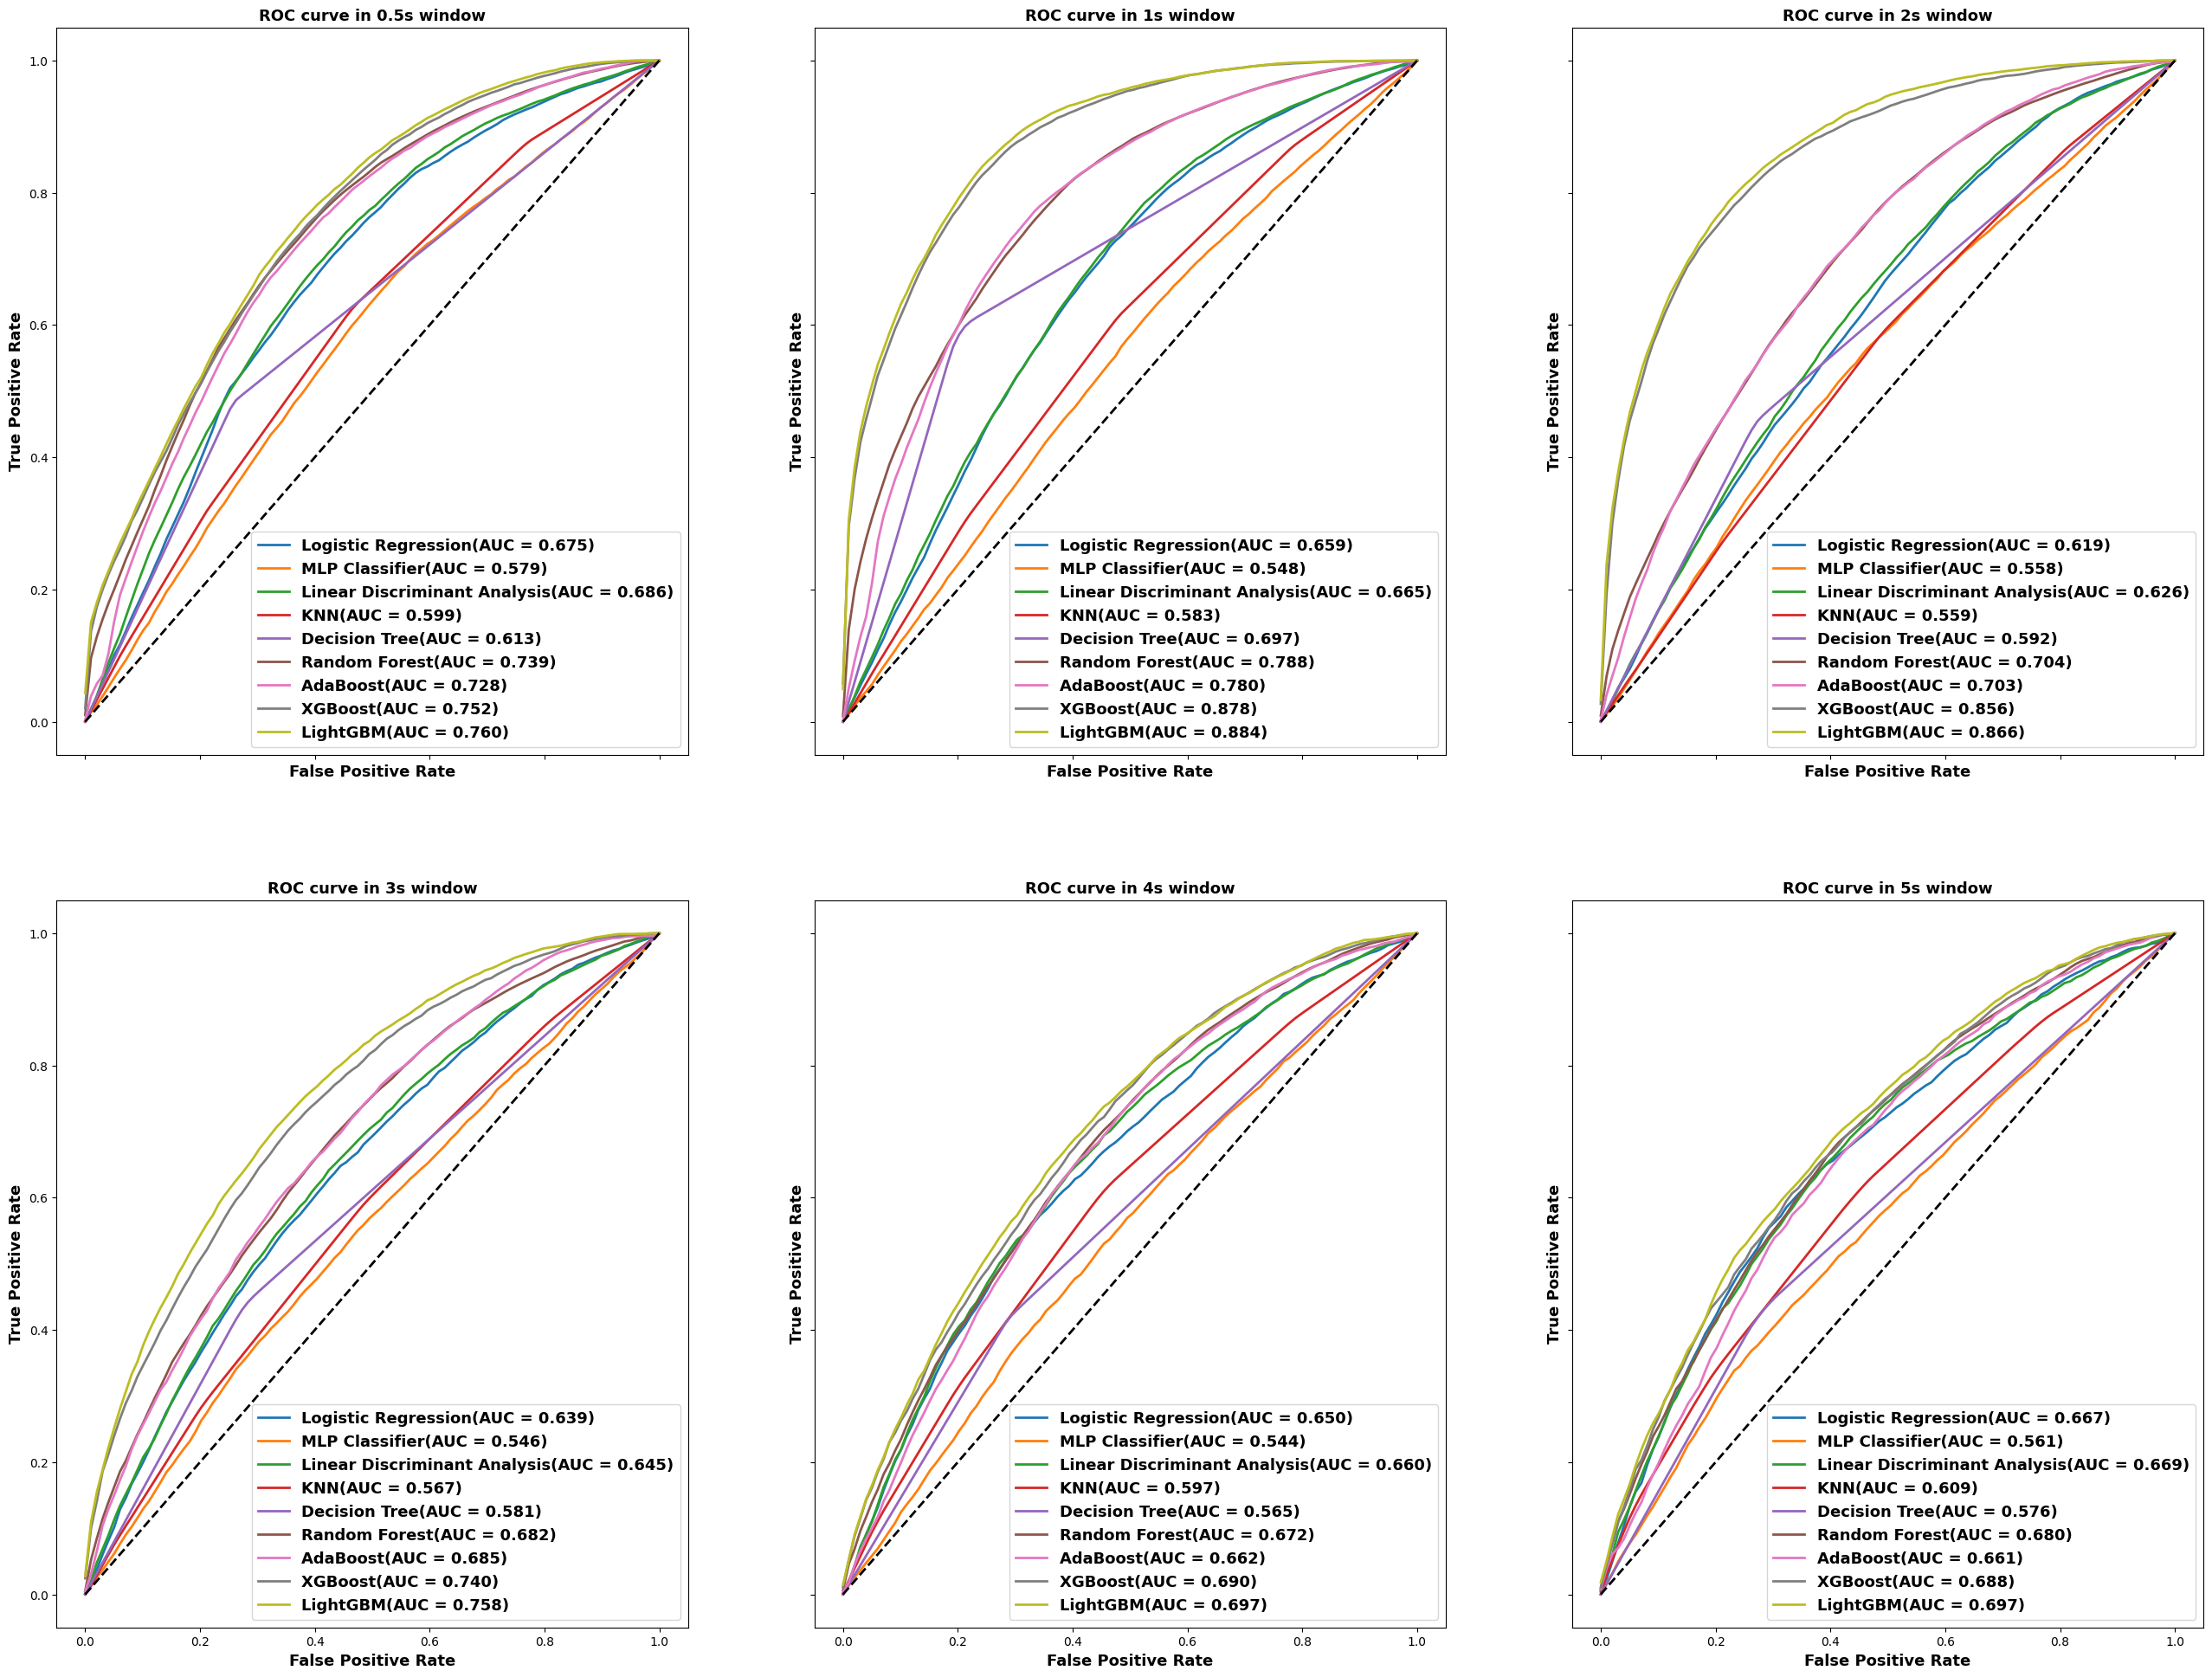

In [ ]:
datasets = [(X_0_5s_d, y_0_5s_d), (X_1s_d, y_1s_d), (X_2s_d, y_2s_d), (X_3s_d, y_3s_d), (X_4s_d, y_4s_d), (X_5s_d, y_5s_d)]
labels = [0.5, 1, 2, 3, 4, 5]
random_state = np.random.RandomState(0)
np.random.seed(0)

fig1, ax = plt.subplots(ncols=3, figsize=[32, 24], nrows=2, sharex=True, sharey=True)

class_combinations = [(0, [1, 2]), (1, [0, 2]), (2, [0, 1])]
class_labels = ['Baseline vs (Attention, Distraction)', 'Distraction vs (Baseline, Attention)', 'Attention vs (Baseline, Distraction)']

for i, (x, y) in enumerate(datasets):
    print('Processing', i)
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=random_state)),
        ('MLP Classifier', MLPClassifier(random_state=random_state)),
        ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
        ('KNN', KNeighborsClassifier()),
        ('Decision Tree', DecisionTreeClassifier(random_state=random_state)),
        ('Random Forest', RandomForestClassifier(random_state=random_state)),
        ('AdaBoost', AdaBoostClassifier(random_state=random_state)),
        ('XGBoost', xgb.XGBClassifier(random_state=random_state)),
        ('LightGBM', lgb.LGBMClassifier(random_state=random_state))
    ]

    mean_fpr = np.linspace(0, 1, 100)

    mean_tprs_micro = []
    mean_aucs_micro = []

    for name, clf in classifiers:
        cv = KFold(n_splits=5, shuffle=True)
        tprs_micro = []
        aucs_micro = []

        for idx, (class_idx, rest_classes) in enumerate(class_combinations):
            for train, test in cv.split(x, y):
                clf.fit(x.iloc[train], y.iloc[train])
                prediction = clf.predict_proba(x.iloc[test])

                lb = LabelBinarizer()
                lb.fit(y)
                y_test_bin = lb.transform(y.iloc[test])
                y_test_bin_one_vs_rest = np.hstack((y_test_bin[:, class_idx].reshape(-1, 1), y_test_bin[:, rest_classes]))

                fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), prediction.ravel())
                tprs_micro.append(interp(mean_fpr, fpr_micro, tpr_micro))
                roc_auc_micro = auc(fpr_micro, tpr_micro)
                aucs_micro.append(roc_auc_micro)

        mean_tpr_micro = np.mean(tprs_micro, axis=0)
        mean_auc_micro = np.mean(aucs_micro)
        mean_tprs_micro.append(mean_tpr_micro)
        mean_aucs_micro.append(mean_auc_micro)

        ax.flat[i].plot(mean_fpr, mean_tpr_micro, label='%s(AUC = %0.3f)' % (name, mean_auc_micro), lw=2)

    ax.flat[i].plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
    ax.flat[i].set_xlabel('False Positive Rate', fontweight='bold', fontsize='13')
    ax.flat[i].set_ylabel('True Positive Rate', fontweight='bold', fontsize='13')
    ax.flat[i].set_title('ROC curve in ' + str(labels[i]) + 's window', fontweight='bold', fontsize='13')
    ax.flat[i].legend(loc='lower right', prop={'weight': 'bold', 'size': '13'})
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')

plt.show()


### Benchmark function

In [ ]:
def benchmark_models_3(X, y):
    models = {
        'Logistic Regression': LogisticRegression(multi_class='auto'),
        'Ridge Classifier': RidgeClassifier(),
        'SGD Classifier': SGDClassifier(),
        'Support Vector Classifier': SVC(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'MLP Classifier': MLPClassifier(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'KNN': KNeighborsClassifier(),
        'XGBoost': xgb.XGBClassifier(objective='multi:softmax'),
        'LightGBM': lgb.LGBMClassifier()
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=1)

    scoring = {'accuracy': 'accuracy',
               'f1_score_micro': 'f1_micro',
               'f1_score_macro': 'f1_macro',
               'recall_micro': 'recall_micro',
               'recall_macro': 'recall_macro',
               'precision_micro': 'precision_micro',
               'precision_macro': 'precision_macro'}

    results = pd.DataFrame(columns=['Accuracy', 'F1 Score ', 'Recall ', 'Precision'])

    for name, model in models.items():
        if isinstance(model, (LogisticRegression, RidgeClassifier, SGDClassifier, SVC)):
            model = OneVsRestClassifier(model)
        elif isinstance(model, (lgb.LGBMClassifier)):
            model = model.set_params(objective='multiclass')

        scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
        results.loc[name] = [
            scores['test_accuracy'].mean(),
            scores['test_f1_score_micro'].mean(),
            scores['test_recall_micro'].mean(),
            scores['test_precision_micro'].mean()
        ]

    return results


#### Benchmark for think-aloud with 1s window size

In [ ]:
benchmark_models_3(X_1s_c, y_1s_c)

,Accuracy,F1 Score,Recall,Precision
Logistic Regression,0.467340,0.230094,0.332089,0.273849
Ridge Classifier,0.474536,0.298403,0.352144,0.330471
SGD Classifier,0.410349,0.223398,0.327652,0.230826
Support Vector Classifier,0.456167,0.265802,0.333325,0.331175
Decision Tree,0.616741,0.536191,0.536152,0.536381
Random Forest,0.606136,0.438700,0.474022,0.533470
AdaBoost,0.616740,0.464920,0.491318,0.505056
MLP Classifier,0.330809,0.268063,0.332663,0.338489
Linear Discriminant Analysis,0.467718,0.301347,0.349265,0.337636
KNN,0.418104,0.311377,0.330046,0.329524


####Benchmark for Attention/Distraction with 1s window size

In [ ]:
benchmark_models_3(X_1s_d, y_1s_d)

,Accuracy,F1 Score,Recall,Precision
Logistic Regression,0.464501,0.228703,0.331336,0.361646
Ridge Classifier,0.468475,0.309193,0.352874,0.399363
SGD Classifier,0.383266,0.227920,0.348567,0.302022
Support Vector Classifier,0.455977,0.273693,0.338609,0.363239
Decision Tree,0.587589,0.526627,0.527106,0.526839
Random Forest,0.601402,0.474372,0.486234,0.572072
AdaBoost,0.620716,0.506600,0.512946,0.558279
MLP Classifier,0.352206,0.274485,0.335786,0.335981
Linear Discriminant Analysis,0.467717,0.336122,0.363104,0.424241
KNN,0.414509,0.331591,0.339346,0.343569


###Permutation Importance

####Attention/Distraction

In [ ]:
RANDOM_STATE = 1
kf = KFold(n_splits=5)
clf = lgb.LGBMClassifier()
X, y = X_1s_d, y_1s_d
perm_importances = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_test, y_test)
    perm_importances.append(perm)

# Calculate the importance scores for each fold
importance_scores = np.array([perm.feature_importances_ for perm in perm_importances])

# Calculate summary statistics for each feature
min_scores = np.min(importance_scores, axis=0)
q1_scores = np.percentile(importance_scores, 25, axis=0)
mean_scores = np.mean(importance_scores, axis=0)
median_scores = np.median(importance_scores, axis=0)
q3_scores = np.percentile(importance_scores, 75, axis=0)
max_scores = np.max(importance_scores, axis=0)

# Create a DataFrame with feature names as index
summary_df = pd.DataFrame({
    'Min': min_scores,
    'Q1': q1_scores,
    'Mean': mean_scores,
    'Median': median_scores,
    'Q3': q3_scores,
    'Max': max_scores
}, index=X.columns)

# Print the summary DataFrame
print(summary_df)


Define group names as a list for 'group' column

In [ ]:
items = (['Temporal & Movement'] * 5) + (['Gaze & Pupil'] * 45) + (['Head Movement & Orientation'] * 17)

#### Preprocess the summary_df contains permutation importance for forestplot

In [ ]:
summary_df['group'] = items
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index': 'label'})

In [ ]:
sorted_grouped_df = summary_df.groupby('group', group_keys=False).apply(lambda group: group.sort_values(by='Median', ascending=False))

In [ ]:
filtered_df = sorted_grouped_df.groupby('group').head(5)
filtered_df = filtered_df.reset_index(drop = True)
filtered_df_2 = filtered_df
filtered_df_2['Median'] = filtered_df_2['Median'] * 100
filtered_df_2['Q1'] = filtered_df_2['Q1'] * 100
filtered_df_2['Q3'] = filtered_df_2['Q3'] * 100

In [ ]:
filtered_df_2

,label,Min,Q1,Mean,Median,Q3,Max,group
0,SD of Gaze direction right Z,-0.000947,1.515152e-01,0.001931,0.264901,0.265152,0.003788,Gaze & Pupil
1,avg of Gaze point X,-0.006818,1.515152e-01,0.000530,0.227058,0.284091,0.002841,Gaze & Pupil
2,SD of Fixation point Y,-0.001515,-1.893939e-02,0.002121,0.227058,0.397727,0.006061,Gaze & Pupil
3,avg of Gaze direction left Y,-0.010038,-4.356061e-01,-0.000379,0.170455,0.359508,0.007197,Gaze & Pupil
4,avg of Gaze direction right X,-0.001136,-1.892148e-02,0.001477,0.113636,0.189394,0.005682,Gaze & Pupil
5,Trajectory Length Accelerometer,0.000568,4.356061e-01,0.004848,0.473485,0.643939,0.008144,Head Movement & Orientation
6,avg of Gyro X,0.000568,1.702933e-01,0.002689,0.227273,0.284091,0.006061,Head Movement & Orientation
7,abs_gyro_z,-0.006061,1.325758e-01,0.001022,0.227058,0.303030,0.004545,Head Movement & Orientation
8,SD of Accelerometer X,-0.000378,1.110223e-15,0.002235,0.189394,0.454545,0.005114,Head Movement & Orientation
9,SD of Accelerometer Y,-0.000947,-7.575758e-02,0.001439,0.189215,0.340909,0.003598,Head Movement & Orientation


####Forestplot

<Axes: xlabel='Decrease in Accuracy Score % '>

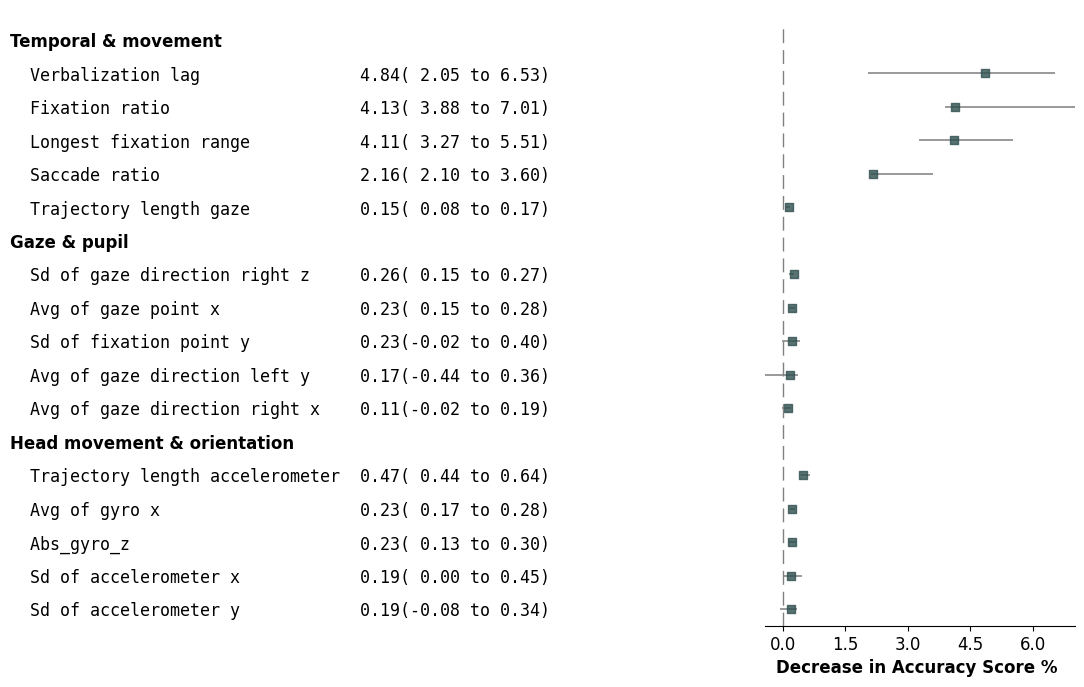

In [ ]:
fp.forestplot(filtered_df_2,  # the dataframe with results data
              estimate='Median',  # col containing estimated effect size
              ll='Q1', hl='Q3',  # columns containing conf. int. lower and higher limits
              varlabel='label',  # column containing variable label
              capitalize="capitalize",  # Capitalize labels
              groupvar="group",  # Add variable groupings
              #decimal_precision=4,
              group_order=['Temporal & Movement', 'Gaze & Pupil', 'Head Movement & Orientation'],
              #ylabel="Confidence interval",  # y-label title
              xlabel="Decrease in Accuracy Score % ",  # x-label title
              **{#"marker": "D",  # set maker symbol as diamond
                 #"markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                }
              )

#### Think-aloud(Lightgbm model with 1s window size) permutation importance

In [ ]:
RANDOM_STATE = 1
kf = KFold(n_splits=5)
clf = lgb.LGBMClassifier()
X, y = X_1s_c, y_1s_c
perm_importances = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_test, y_test)
    perm_importances.append(perm)

importance_scores = np.array([perm.feature_importances_ for perm in perm_importances])

min_scores = np.min(importance_scores, axis=0)
q1_scores = np.percentile(importance_scores, 25, axis=0)
mean_scores = np.mean(importance_scores, axis=0)
median_scores = np.median(importance_scores, axis=0)
q3_scores = np.percentile(importance_scores, 75, axis=0)
max_scores = np.max(importance_scores, axis=0)

summary_df = pd.DataFrame({
    'Min': min_scores,
    'Q1': q1_scores,
    'Mean': mean_scores,
    'Median': median_scores,
    'Q3': q3_scores,
    'Max': max_scores
}, index=X.columns)


#### Preprocess the summary_df contains permutation importance for forestplot

In [ ]:
summary_df['group'] = items
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index': 'label'})


In [ ]:
sorted_grouped_df = summary_df.groupby('group', group_keys=False).apply(lambda group: group.sort_values(by='Median', ascending=False))

In [ ]:
filtered_df = sorted_grouped_df.groupby('group').head(5)
filtered_df = filtered_df.reset_index(drop = True)
filtered_df_2 = filtered_df
filtered_df_2['Median'] = filtered_df_2['Median'] * 100
filtered_df_2['Q1'] = filtered_df_2['Q1'] * 100
filtered_df_2['Q3'] = filtered_df_2['Q3'] * 100

In [ ]:
filtered_df_2

,label,Min,Q1,Mean,Median,Q3,Max,group
0,SD of Fixation point Y,-0.001136,-3.787879e-02,0.002877,3.977273e-01,4.734848e-01,0.007190,Gaze & Pupil
1,SD of Gaze point 3D X,-0.007765,-1.325758e-01,0.000454,2.840909e-01,4.166667e-01,0.004352,Gaze & Pupil
2,SD of Pupil diameter right,-0.004735,-1.892148e-02,0.000606,1.704545e-01,2.462121e-01,0.003788,Gaze & Pupil
3,Abs change of Gaze point 3D Y,-0.002462,7.568590e-02,0.000833,1.515152e-01,1.893939e-01,0.002462,Gaze & Pupil
4,avg of Gaze direction right X,-0.006250,0.000000e+00,0.000757,1.515152e-01,3.784295e-01,0.004735,Gaze & Pupil
5,Trajectory Length Accelerometer,-0.006250,-1.110223e-15,0.000719,2.272727e-01,2.272727e-01,0.005298,Head Movement & Orientation
6,abs_gyro_z,-0.006629,-3.409091e-01,-0.001515,5.681818e-02,9.460738e-02,0.000947,Head Movement & Orientation
7,SD of Gyro Y,-0.005114,-1.325758e-01,-0.000833,5.676443e-02,7.575758e-02,0.000947,Head Movement & Orientation
8,SD of Accelerometer Z,-0.005114,-4.356061e-01,-0.001061,1.893939e-02,3.787879e-02,0.003595,Head Movement & Orientation
9,SD of Gyro X,-0.004356,-2.838221e-01,-0.000909,-1.110223e-15,2.220446e-15,0.002652,Head Movement & Orientation


#### Forestplot

<Axes: xlabel='Decrease in Accuracy Score % '>

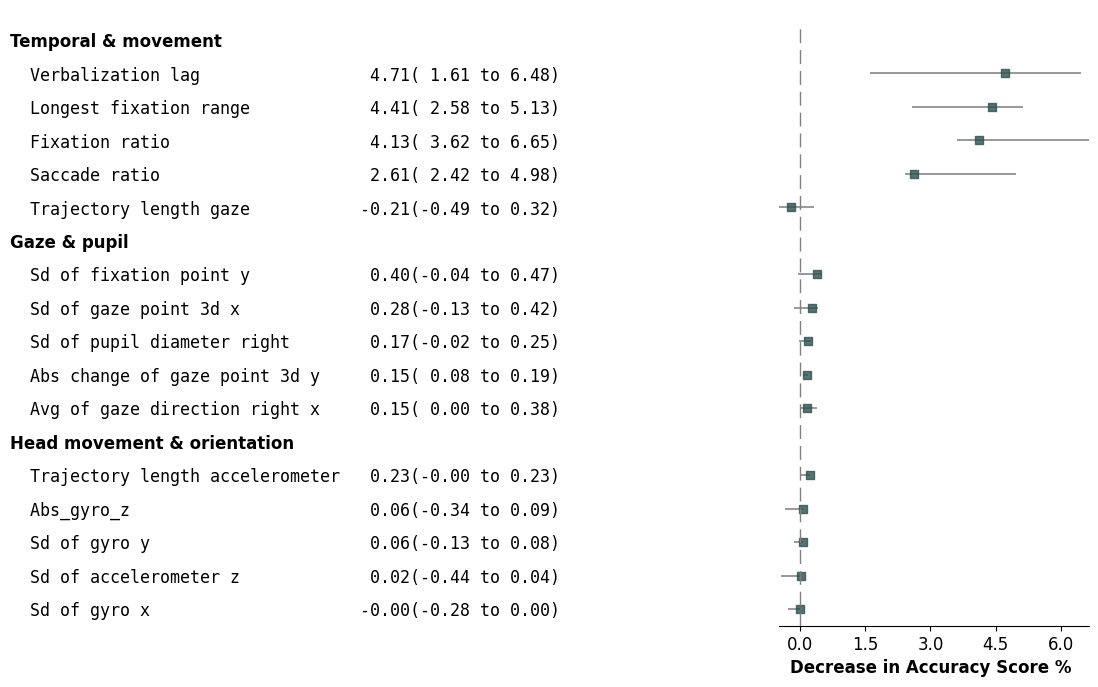

In [ ]:
fp.forestplot(filtered_df_2,  # the dataframe with results data
              estimate='Median',  # col containing estimated effect size
              ll='Q1', hl='Q3',  # columns containing conf. int. lower and higher limits
              varlabel='label',  # column containing variable label
              capitalize="capitalize",  # Capitalize labels
              groupvar="group",  # Add variable groupings
              #decimal_precision=4,
              group_order=['Temporal & Movement', 'Gaze & Pupil', 'Head Movement & Orientation'],
              #ylabel="Confidence interval",  # y-label title
              xlabel="Decrease in Accuracy Score % ",  # x-label title
              **{#"marker": "D",  # set maker symbol as diamond
                 #"markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                }
              )